# BCM vs APHRODITE

24th October

In [34]:
import sys
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code/')
from load import aphrodite
import pandas as pd
from utils import areal_plots
from cartopy import crs as ccrs
from cartopy import feature as cf
import matplotlib.pyplot as plt

## Load APHRODITE data

In [7]:
aphro_ds= aphrodite.collect_APHRO('hma', minyear='1961', maxyear='1961-12-31')
ds_aphro


<xarray.Dataset>
Dimensions:  (lon: 80, lat: 60, time: 12)
Coordinates:
  * lon      (lon) float64 65.12 65.38 65.62 65.88 ... 84.12 84.38 84.62 84.88
  * lat      (lat) float64 25.12 25.38 25.62 25.88 ... 39.12 39.38 39.62 39.88
  * time     (time) datetime64[ns] 1961-01-01 1961-02-01 ... 1961-12-01
Data variables:
    tp       (time, lat, lon) float32 ...
Attributes:
    long_name:          daily precipitation analysis interpolated onto 0.25de...
    units:              mm/day
    level_description:  Earth surface
    plot_legend:        APHRODITE

In [8]:
aphro_ds = aphro_ds[["time", "lon", "lat", "tp"]]
aphro_ds

<xarray.Dataset>
Dimensions:  (time: 12, lon: 80, lat: 60)
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01 1961-02-01 ... 1961-12-01
  * lon      (lon) float64 65.12 65.38 65.62 65.88 ... 84.12 84.38 84.62 84.88
  * lat      (lat) float64 25.12 25.38 25.62 25.88 ... 39.12 39.38 39.62 39.88
Data variables:
    tp       (time, lat, lon) float32 ...
Attributes:
    long_name:          daily precipitation analysis interpolated onto 0.25de...
    units:              mm/day
    level_description:  Earth surface
    plot_legend:        APHRODITE

### Generate grid to predict BCM onto

In [9]:
aphro_df = aphro_ds.to_dataframe()

In [10]:
aphro_df.reset_index(inplace=True)
aphro_df[['time', 'lon','lat']].to_csv('data/aphro_grid.csv', index=False)

In [11]:
aphro_df

,time,lon,lat,tp
0,1961-01-01,65.125,25.125,NaN
1,1961-01-01,65.125,25.375,0.218884
2,1961-01-01,65.125,25.625,0.250606
3,1961-01-01,65.125,25.875,0.256682
4,1961-01-01,65.125,26.125,0.270556
...,...,...,...,...
57595,1961-12-01,84.875,38.875,0.009503
57596,1961-12-01,84.875,39.125,0.008894
57597,1961-12-01,84.875,39.375,0.008626
57598,1961-12-01,84.875,39.625,0.007989


## Load BCM data

In [12]:
bcm_df = pd.read_csv('data/outputs/bcm_aphrogrid_2rcm_1961.csv')
bcm_df['time'] = pd.to_datetime(bcm_df['time'])

In [13]:
bcm_df.set_index(['time', 'lon', 'lat',], inplace=True)
bcm_ds = bcm_df.to_xarray()
bcm_ds

<xarray.Dataset>
Dimensions:  (time: 12, lon: 80, lat: 60)
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01 1961-02-01 ... 1961-12-01
  * lon      (lon) float64 65.12 65.38 65.62 65.88 ... 84.12 84.38 84.62 84.88
  * lat      (lat) float64 25.12 25.38 25.62 25.88 ... 39.12 39.38 39.62 39.88
Data variables:
    pred0    (time, lon, lat) float64 -1.067 -1.102 -1.136 ... -1.181 -1.166
    var0     (time, lon, lat) float64 0.3204 0.3205 0.3206 ... 0.3371 0.3429
    y_pred   (time, lon, lat) float64 0.6249 0.6026 0.5818 ... 0.555 0.5638

In [15]:
bcm_ds

<xarray.Dataset>
Dimensions:  (time: 12, lon: 80, lat: 60)
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01 1961-02-01 ... 1961-12-01
  * lon      (lon) float64 65.12 65.38 65.62 65.88 ... 84.12 84.38 84.62 84.88
  * lat      (lat) float64 25.12 25.38 25.62 25.88 ... 39.12 39.38 39.62 39.88
Data variables:
    pred0    (time, lon, lat) float64 -1.067 -1.102 -1.136 ... -1.181 -1.166
    var0     (time, lon, lat) float64 0.3204 0.3205 0.3206 ... 0.3371 0.3429
    y_pred   (time, lon, lat) float64 0.6249 0.6026 0.5818 ... 0.555 0.5638
    diff     (time, lat, lon) float64 nan nan nan ... -0.5287 -0.5418 -0.5577

In [19]:
bcm_ds['diffs'] = aphro_ds.tp - bcm_ds.y_pred

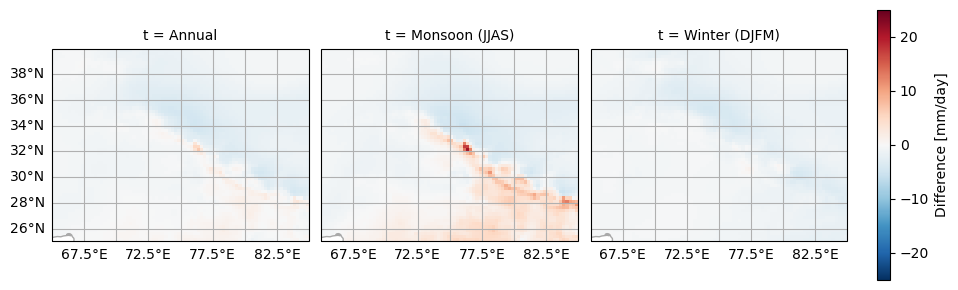

In [42]:
proj = ccrs.PlateCarree()
ds = areal_plots.seasonal_means(bcm_ds.diffs, 'diffs')

ocean_50m = cf.NaturalEarthFeature(
    "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

# Mean facet grid plot
fg = ds.plot(x="lon", y="lat", col="t", sharey=True, subplot_kws={'projection': proj}, cbar_kwargs={
    "label": "Difference [mm/day]", 'pad': 0.03}, vmin=-25, vmax=25, cmap='RdBu_r')

ax0 = fg.axs.flat[0]
gl0 = ax0.gridlines(draw_labels=True)
gl0.top_labels = False
gl0.right_labels = False
ax0.add_feature(ocean_50m)

for ax in fg.axs.flat[1:]:
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    ax.add_feature(ocean_50m)

# plt.subplots_adjust(wspace=0.15)

plt.savefig('plots/test_difference_historical_mean.png', bbox_inches='tight')


In [26]:
trad_df = pd.read_csv('data/outputs/trad_2rcm_1961.csv')
trad_df['time'] = pd.to_datetime(trad_df['time'])

In [27]:
trad_df.set_index(['time', 'lon', 'lat', ], inplace=True)
trad_ds = trad_df.to_xarray()
trad_ds

<xarray.Dataset>
Dimensions:  (time: 60, lon: 90, lat: 40)
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01 1961-02-01 ... 1965-12-01
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 20.25 20.75 21.25 21.75 ... 38.25 38.75 39.25 39.75
Data variables:
    y_pred   (time, lon, lat) float64 0.7575 0.6565 0.4161 ... 0.2619 0.2215

In [30]:
trad_ds_tr = trad_ds.interp_like(aphro_ds)

In [31]:
trad_ds_tr['diffs'] = aphro_ds.tp - trad_ds_tr.y_pred

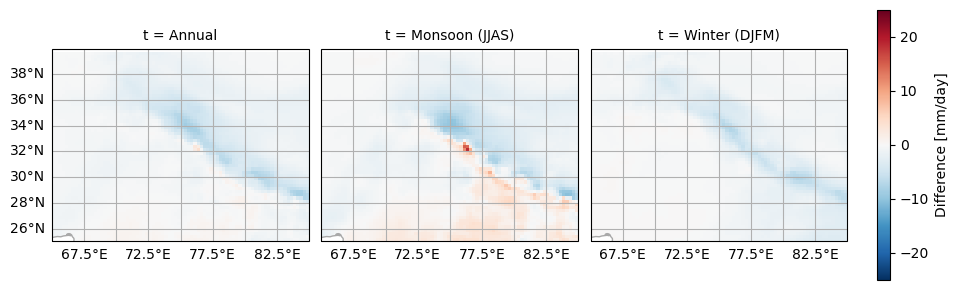

In [43]:
ds = areal_plots.seasonal_means(trad_ds_tr.diffs, 'diffs')

ocean_50m = cf.NaturalEarthFeature(
    "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

# Mean facet grid plot
fg = ds.plot(x="lon", y="lat", col="t", sharey=True, subplot_kws={'projection': proj}, cbar_kwargs={
    "label": "Difference [mm/day]", 'pad': 0.03}, vmin=-25, vmax=25, cmap='RdBu_r')

ax0 = fg.axs.flat[0]
gl0 = ax0.gridlines(draw_labels=True)
gl0.top_labels = False
gl0.right_labels = False
ax0.add_feature(ocean_50m)

for ax in fg.axs.flat[1:]:
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    ax.add_feature(ocean_50m)

# plt.subplots_adjust(wspace=0.15)

plt.savefig('plots/test_difference_historical_trad.png', bbox_inches='tight')
